# Before you begin


1.   Use the [Cloud Resource Manager](https://console.cloud.google.com/cloud-resource-manager) to Create a Cloud Platform project if you do not already have one.
2.   [Enable billing](https://support.google.com/cloud/answer/6293499#enable-billing) for the project.
3.   [Enable BigQuery](https://console.cloud.google.com/flows/enableapi?apiid=bigquery) APIs for the project.


### Provide your credentials to the runtime

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier, RandomForestRegressor

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import pandas as pd

# Use BigQuery through google-cloud-bigquery

See [BigQuery documentation](https://cloud.google.com/bigquery/docs) and [library reference documentation](https://googlecloudplatform.github.io/google-cloud-python/latest/bigquery/usage.html).

The [GSOD sample table](https://bigquery.cloud.google.com/table/bigquery-public-data:samples.gsod) contains weather information collected by NOAA, such as precipitation amounts and wind speeds from late 1929 to early 2010.


### Declare the Cloud project ID which will be used throughout this notebook

In [ ]:
project_id = 'cmpe272-332502'

In [ ]:
from google.cloud import bigquery

client = bigquery.Client(project=project_id)


df = client.query('''
 SELECT  * FROM `bigquery-public-data.epa_historical_air_quality.co_daily_summary` where date_local >= "2009-01-01"
''').to_dataframe()

# df = pd.read_csv("/content/drive/MyDrive/272/final.csv")

In [ ]:
df.head()

,state_code,county_code,site_num,parameter_code,poc,latitude,longitude,datum,parameter_name,sample_duration,pollutant_standard,date_local,units_of_measure,event_type,observation_count,observation_percent,arithmetic_mean,first_max_value,first_max_hour,aqi,method_code,method_name,local_site_name,address,state_name,county_name,city_name,cbsa_name,date_of_last_change
0,2,20,48,42101,1,61.191514,-149.934930,WGS84,Carbon monoxide,1 HOUR,CO 1-hour 1971,2012-10-12,Parts per million,None,24,100.0,1.041667,4.5,7,NaN,54.0,INSTRUMENTAL - NONDISPERSIVE INFRARED,UNITARIAN CHURCH,3201 TURNAGAIN STREET,Alaska,Anchorage,Anchorage,"Anchorage, AK",2018-06-04
1,2,20,52,42101,1,61.215027,-149.903111,WGS84,Carbon monoxide,1 HOUR,CO 1-hour 1971,2012-01-11,Parts per million,None,24,100.0,0.279167,1.3,17,NaN,54.0,INSTRUMENTAL - NONDISPERSIVE INFRARED,DHHS,727 L Street,Alaska,Anchorage,Anchorage,"Anchorage, AK",2016-04-08
2,2,20,52,42101,1,61.215027,-149.903111,WGS84,Carbon monoxide,1 HOUR,CO 1-hour 1971,2012-03-29,Parts per million,None,24,100.0,0.445833,0.9,6,NaN,54.0,INSTRUMENTAL - NONDISPERSIVE INFRARED,DHHS,727 L Street,Alaska,Anchorage,Anchorage,"Anchorage, AK",2016-04-08
3,2,20,52,42101,1,61.215027,-149.903111,WGS84,Carbon monoxide,8-HR RUN AVG END HOUR,CO 8-hour 1971,2012-11-01,Parts per million,None,24,100.0,0.379167,0.7,0,8.0,NaN,-,DHHS,727 L Street,Alaska,Anchorage,Anchorage,"Anchorage, AK",2016-04-08
4,6,29,2012,42101,1,35.331612,-118.999961,NAD83,Carbon monoxide,1 HOUR,CO 1-hour 1971,2012-08-21,Parts per million,None,21,88.0,0.261905,0.4,9,NaN,54.0,INSTRUMENTAL - NONDISPERSIVE INFRARED,Bakersfield-Muni,2000 South Union Ave. Bakersfield CA 93307,California,Kern,Bakersfield,"Bakersfield, CA",2016-04-09


### Describe the sampled data

In [ ]:
df.describe()

,state_code,county_code,site_num,parameter_code,poc,latitude,longitude,observation_count,observation_percent,arithmetic_mean,first_max_value,first_max_hour,aqi,method_code
count,2.356603e+06,2.356603e+06,2.356603e+06,2356603.0,2.356603e+06,2.356603e+06,2.356603e+06,2.356603e+06,2.356603e+06,2.356603e+06,2.356603e+06,2.356603e+06,1.178308e+06,1.178295e+06
mean,2.478019e+01,7.650256e+01,9.011486e+02,42101.0,1.147431e+00,3.752664e+01,-9.805205e+01,2.327752e+01,9.704557e+01,3.163669e-01,5.150626e-01,7.932945e+00,4.993341e+00,2.345471e+02
std,1.810628e+01,1.058310e+02,1.802894e+03,0.0,6.839221e-01,5.549900e+00,1.938084e+01,2.158731e+00,8.937323e+00,2.552046e-01,5.030489e-01,7.915253e+00,4.347717e+00,2.309118e+02
min,1.000000e+00,1.000000e+00,1.000000e+00,42101.0,1.000000e+00,1.800956e+01,-1.593662e+02,1.000000e+00,4.000000e+00,-5.000000e-01,-5.000000e-01,0.000000e+00,0.000000e+00,4.100000e+01
25%,6.000000e+00,1.900000e+01,1.100000e+01,42101.0,1.000000e+00,3.399958e+01,-1.174006e+02,2.300000e+01,9.600000e+01,1.750000e-01,2.040000e-01,0.000000e+00,2.000000e+00,5.400000e+01
50%,2.400000e+01,4.900000e+01,4.100000e+01,42101.0,1.000000e+00,3.819360e+01,-9.525759e+01,2.400000e+01,1.000000e+02,2.625000e-01,4.000000e-01,6.000000e+00,3.000000e+00,9.300000e+01
75%,3.900000e+01,9.500000e+01,1.007000e+03,42101.0,1.000000e+00,4.106040e+01,-8.059232e+01,2.400000e+01,1.000000e+02,4.000000e-01,6.000000e-01,1.500000e+01,7.000000e+00,5.540000e+02
max,8.000000e+01,8.100000e+02,9.997000e+03,42101.0,9.000000e+00,6.484569e+01,-6.605224e+01,2.400000e+01,1.000000e+02,4.566667e+01,5.000000e+01,2.300000e+01,4.530000e+02,5.930000e+02


In [ ]:
#df.to_csv("/content/drive/MyDrive/272/final.csv", index=False)

# Data Preprocessing

In [ ]:
import pandas as pd

In [ ]:
df['date_local'] = pd.to_datetime(df['date_local'])

In [ ]:
df.head()

,state_code,county_code,site_num,parameter_code,poc,latitude,longitude,datum,parameter_name,sample_duration,pollutant_standard,date_local,units_of_measure,event_type,observation_count,observation_percent,arithmetic_mean,first_max_value,first_max_hour,aqi,method_code,method_name,local_site_name,address,state_name,county_name,city_name,cbsa_name,date_of_last_change
0,2,20,48,42101,1,61.191514,-149.934930,WGS84,Carbon monoxide,1 HOUR,CO 1-hour 1971,2012-10-12,Parts per million,None,24,100.0,1.041667,4.5,7,NaN,54.0,INSTRUMENTAL - NONDISPERSIVE INFRARED,UNITARIAN CHURCH,3201 TURNAGAIN STREET,Alaska,Anchorage,Anchorage,"Anchorage, AK",2018-06-04
1,2,20,52,42101,1,61.215027,-149.903111,WGS84,Carbon monoxide,1 HOUR,CO 1-hour 1971,2012-01-11,Parts per million,None,24,100.0,0.279167,1.3,17,NaN,54.0,INSTRUMENTAL - NONDISPERSIVE INFRARED,DHHS,727 L Street,Alaska,Anchorage,Anchorage,"Anchorage, AK",2016-04-08
2,2,20,52,42101,1,61.215027,-149.903111,WGS84,Carbon monoxide,1 HOUR,CO 1-hour 1971,2012-03-29,Parts per million,None,24,100.0,0.445833,0.9,6,NaN,54.0,INSTRUMENTAL - NONDISPERSIVE INFRARED,DHHS,727 L Street,Alaska,Anchorage,Anchorage,"Anchorage, AK",2016-04-08
3,2,20,52,42101,1,61.215027,-149.903111,WGS84,Carbon monoxide,8-HR RUN AVG END HOUR,CO 8-hour 1971,2012-11-01,Parts per million,None,24,100.0,0.379167,0.7,0,8.0,NaN,-,DHHS,727 L Street,Alaska,Anchorage,Anchorage,"Anchorage, AK",2016-04-08
4,6,29,2012,42101,1,35.331612,-118.999961,NAD83,Carbon monoxide,1 HOUR,CO 1-hour 1971,2012-08-21,Parts per million,None,21,88.0,0.261905,0.4,9,NaN,54.0,INSTRUMENTAL - NONDISPERSIVE INFRARED,Bakersfield-Muni,2000 South Union Ave. Bakersfield CA 93307,California,Kern,Bakersfield,"Bakersfield, CA",2016-04-09


In [ ]:
df_extract = df[["state_code","county_code", "date_local","arithmetic_mean", "parameter_name", "city_name"]]

In [ ]:
df_extract.head()

,state_code,county_code,date_local,arithmetic_mean,parameter_name,city_name
0,2,20,2012-10-12,1.041667,Carbon monoxide,Anchorage
1,2,20,2012-01-11,0.279167,Carbon monoxide,Anchorage
2,2,20,2012-03-29,0.445833,Carbon monoxide,Anchorage
3,2,20,2012-11-01,0.379167,Carbon monoxide,Anchorage
4,6,29,2012-08-21,0.261905,Carbon monoxide,Bakersfield


In [ ]:
df_extract["year"] = pd.DatetimeIndex(df_extract['date_local']).year  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_extract["month"] = pd.DatetimeIndex(df_extract['date_local']).month
#df_extract["day"] = pd.DatetimeIndex(df_extract['date_local']).day   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_extract.drop(["date_local"], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df_extract["state_code"] = df_extract["state_code"].astype(int)
df_extract["county_code"] = df_extract["county_code"].astype(int)
# df_extract["site_num"] = df_extract["site_num"].astype(int)

# encoder = LabelEncoder()
# df_extract["state_name"] = scaler.fit_transform(df_extract["state_name"])
# df_extract[""]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_extract.head()

,state_code,county_code,arithmetic_mean,parameter_name,city_name,year,month
0,2,20,1.041667,Carbon monoxide,Anchorage,2012,10
1,2,20,0.279167,Carbon monoxide,Anchorage,2012,1
2,2,20,0.445833,Carbon monoxide,Anchorage,2012,3
3,2,20,0.379167,Carbon monoxide,Anchorage,2012,11
4,6,29,0.261905,Carbon monoxide,Bakersfield,2012,8


In [ ]:
df_model_charts = df_extract[["state_code", "county_code", "arithmetic_mean", "year", "month"]]

In [ ]:
df_model_map = df_extract[["state_code", "county_code", "arithmetic_mean", "year"]]

In [ ]:
df_model_pollutant = df_extract[["state_code", "county_code", "year", "city_name", "arithmetic_mean"]]
df_model_pollutant.head()

,state_code,county_code,year,city_name,arithmetic_mean
0,2,20,2012,Anchorage,1.041667
1,2,20,2012,Anchorage,0.279167
2,2,20,2012,Anchorage,0.445833
3,2,20,2012,Anchorage,0.379167
4,6,29,2012,Bakersfield,0.261905


In [ ]:
df_model_pollutant = df_model_pollutant[df_model_pollutant["city_name"]!="Not in a city"].reset_index(drop=True)
df_model_pollutant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2168402 entries, 0 to 2168401
Data columns (total 5 columns):
 #   Column           Dtype  
---  ------           -----  
 0   state_code       int64  
 1   county_code      int64  
 2   year             int64  
 3   city_name        object 
 4   arithmetic_mean  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 82.7+ MB


In [ ]:
df_model_smap = df_extract[["state_code", "year", "arithmetic_mean"]]
df_model_smap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356603 entries, 0 to 2356602
Data columns (total 3 columns):
 #   Column           Dtype  
---  ------           -----  
 0   state_code       int64  
 1   year             int64  
 2   arithmetic_mean  float64
dtypes: float64(1), int64(2)
memory usage: 53.9 MB


# Model Chart:

In [ ]:
df_g = df_model_charts.groupby(["state_code", "county_code","year","month"])["arithmetic_mean"].mean().reset_index()

In [ ]:
df_g.head()

,state_code,county_code,year,month,arithmetic_mean
0,1,73,2009,1,0.798803
1,1,73,2009,2,0.621027
2,1,73,2009,3,0.344531
3,1,73,2009,4,0.285466
4,1,73,2009,5,0.329127


In [ ]:
df_g.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23631 entries, 0 to 23630
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   state_code       23631 non-null  int64  
 1   county_code      23631 non-null  int64  
 2   year             23631 non-null  int64  
 3   month            23631 non-null  int64  
 4   arithmetic_mean  23631 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 923.2 KB


In [ ]:
X = df_g.drop(["arithmetic_mean"], axis=1)
y = df_g[["arithmetic_mean"]]

In [ ]:
train_X = X[:23000]
test_X = X[23000:]
train_y = y[:23000]
test_y = y[23000:]

In [ ]:
ddict = {'state_code':[],
    'county_code':[],
    'year':[],
    'month' : []
}
ddf = pd.DataFrame(ddict)
for i in range(2022, 2027):
  for j in (list(X["state_code"].unique())):
    for k in (list(X[X["state_code"]==j]["county_code"].unique())):
      for l in range(1,13):
        ddf.loc[len(ddf.index)] = [j, k, i, l]

In [ ]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_X)
test_scaled = scaler.transform(test_X)
evalchart = scaler.transform(ddf)

In [ ]:
xg = xgb.XGBRegressor()
xg.fit(train_scaled, train_y)
pred = xg.predict(test_scaled)

[14:19:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
print("MSE: ", mean_squared_error(pred, test_y))

MSE:  0.4372423573777129


In [ ]:
gbr = RandomForestRegressor()
gbr.fit(train_scaled, train_y)
pred1 = gbr.predict(test_scaled)
print("MSE: ", mean_squared_error(pred1, test_y))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE:  0.44557624376177185


In [ ]:
import numpy as np
save_charts = gbr.predict(evalchart)
ddf["carbonscore"] = save_charts
ddf.head()

,state_code,county_code,year,month,carbonscore
0,1.0,73.0,2022.0,1.0,0.405842
1,1.0,73.0,2022.0,2.0,0.357397
2,1.0,73.0,2022.0,3.0,0.265187
3,1.0,73.0,2022.0,4.0,0.243504
4,1.0,73.0,2022.0,5.0,0.243405


In [ ]:
ddf["state_code"] = ddf["state_code"].astype(int)
ddf["county_code"] = ddf["county_code"].astype(int)
ddf["year"] = ddf["year"].astype(int)
ddf["month"] = ddf["month"].astype(int)

In [ ]:
ddf.head()

,state_code,county_code,year,month,carbonscore
0,1,73,2022,1,0.405842
1,1,73,2022,2,0.357397
2,1,73,2022,3,0.265187
3,1,73,2022,4,0.243504
4,1,73,2022,5,0.243405


In [ ]:
ddf.to_csv("/content/drive/MyDrive/272/charts.csv", index=False)

In [ ]:
import pickle
filename = '/content/drive/MyDrive/272/charts.pkl'
pickle.dump(gbr, open(filename, 'wb'))

# Model 2

In [ ]:
df_g_map = df_model_map.groupby(["state_code", "county_code","year"])["arithmetic_mean"].mean().reset_index()

In [ ]:
df_g_map.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   state_code       2050 non-null   int64  
 1   county_code      2050 non-null   int64  
 2   year             2050 non-null   int64  
 3   arithmetic_mean  2050 non-null   float64
dtypes: float64(1), int64(3)
memory usage: 64.2 KB


In [ ]:
X_map = df_g_map.drop(["arithmetic_mean"], axis=1)
y_map = df_g_map[["arithmetic_mean"]]

In [ ]:
train_X_map = X_map[:2000]
test_X_map = X_map[2000:]
train_y_map = y_map[:2000]
test_y_map = y_map[2000:]

In [ ]:
train_X_map

,state_code,county_code,year
0,1,73,2009
1,1,73,2010
2,1,73,2011
3,1,73,2012
4,1,73,2013
...,...,...,...
1995,56,39,2014
1996,56,39,2015
1997,56,39,2016
1998,56,39,2017


In [ ]:
ddict1 = {'state_code':[],
    'county_code':[],
    'year':[]
}
ddf1 = pd.DataFrame(ddict1)
for i in range(2022, 2027):
  for j in (list(X["state_code"].unique())):
    for k in (list(X[X["state_code"]==j]["county_code"].unique())):
      ddf1.loc[len(ddf1.index)] = [j, k, i]

In [ ]:
scaler = MinMaxScaler()
train_scaled_map = scaler.fit_transform(train_X_map)
test_scaled_map = scaler.transform(test_X_map)
evalmap = scaler.transform(ddf1)

In [ ]:
gbr_map = GradientBoostingRegressor()
gbr_map.fit(train_scaled_map, train_y_map)
pred2 = gbr_map.predict(test_scaled_map)
print("MSE: ", mean_squared_error(pred2, test_y_map))

MSE:  0.37776601510927826


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
rfr = RandomForestRegressor()
rfr.fit(train_scaled_map, train_y_map)
pred2 = rfr.predict(test_scaled_map)
print("MSE: ", mean_squared_error(pred2, test_y_map))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


MSE:  0.35347020286129016


In [ ]:
save_map = gbr_map.predict(evalmap)
ddf1["carbonscore"] = save_map
ddf1.head()

,state_code,county_code,year,carbonscore
0,1.0,73.0,2022.0,0.327227
1,2.0,20.0,2022.0,0.535235
2,2.0,90.0,2022.0,0.421765
3,4.0,12.0,2022.0,0.221636
4,4.0,13.0,2022.0,0.298664


In [ ]:
ddf1["state_code"] = ddf1["state_code"].astype(int)
ddf1["county_code"] = ddf1["county_code"].astype(int)
ddf1["year"] = ddf1["year"].astype(int)
ddf1.head()

,state_code,county_code,year,carbonscore
0,1,73,2022,0.327227
1,2,20,2022,0.535235
2,2,90,2022,0.421765
3,4,12,2022,0.221636
4,4,13,2022,0.298664


In [ ]:
ddf1.to_csv("/content/drive/MyDrive/272/map.csv", index=False)

In [ ]:
import pickle
filename = '/content/drive/MyDrive/272/map.pkl'
pickle.dump(gbr_map, open(filename, 'wb'))

# Model Pollutant

In [ ]:
df_g_pollutant = df_model_pollutant.groupby(["state_code", "county_code","year","city_name"])["arithmetic_mean"].mean().reset_index()
df_g_pollutant.head()

,state_code,county_code,year,city_name,arithmetic_mean
0,1,73,2009,Birmingham,0.560884
1,1,73,2009,Fairfield,0.478250
2,1,73,2010,Birmingham,0.315640
3,1,73,2010,Fairfield,0.466380
4,1,73,2011,Birmingham,0.332377


In [ ]:
encoder = LabelEncoder()
df_g_pollutant["city_num"] = encoder.fit_transform(df_g_pollutant["city_name"])

In [ ]:
sd = df_g_pollutant[["city_name","city_num"]]
sd.drop_duplicates(keep='first', inplace=True)
dict(sd.values)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


{'Akron': 0,
 'Albany': 1,
 'Albuquerque': 2,
 'Alexandria': 3,
 'Allen Park': 4,
 'Anaheim': 5,
 'Anchorage': 6,
 'Annandale': 7,
 'Arden-Arcade': 8,
 'Arlington': 9,
 'Arvin': 10,
 'Athens': 11,
 'Atlanta': 12,
 'Austin': 13,
 'Azusa': 14,
 'Bakersfield': 15,
 'Baltimore': 16,
 'Barstow': 17,
 'Baton Rouge': 18,
 'Bayamon': 19,
 'Bellevue': 20,
 'Beltsville': 21,
 'Berkeley': 22,
 'Bethel Island': 23,
 'Billings': 24,
 'Birmingham': 25,
 'Bismarck': 26,
 'Blaine': 27,
 'Boise (corporate name Boise City)': 28,
 'Bondville': 29,
 'Boston': 30,
 'Bridgeport': 31,
 'Bristol': 32,
 'Brownsville': 33,
 'Buckeye': 34,
 'Buffalo': 35,
 'Burbank': 36,
 'Burlington': 37,
 'Caguas': 38,
 'Calexico': 39,
 'Camden': 40,
 'Campo': 41,
 'Canton': 42,
 'Capitan': 43,
 'Cedar Rapids': 44,
 'Chandler': 45,
 'Charleroi': 46,
 'Charleston': 47,
 'Charlotte': 48,
 'Cheektowaga': 49,
 'Cherry Tree': 50,
 'Chicago': 51,
 'Chico': 52,
 'Chicopee': 53,
 'Chula Vista': 54,
 'Cicero': 55,
 'Cincinnati': 56,
 '

In [ ]:
X_pollutant = df_g_pollutant.drop(["arithmetic_mean","city_name"], axis=1)
y_pollutant = df_g_pollutant[["arithmetic_mean"]]

In [ ]:
X_pollutant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2564 entries, 0 to 2563
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   state_code   2564 non-null   int64
 1   county_code  2564 non-null   int64
 2   year         2564 non-null   int64
 3   city_num     2564 non-null   int64
dtypes: int64(4)
memory usage: 80.2 KB


In [ ]:
ddict2 = {'state_code':[],
    'county_code':[],
    'year':[],
    'city_num' : []
}
ddf2 = pd.DataFrame(ddict2)
for i in range(2022, 2027):
  for j in (list(X["state_code"].unique())):
    for k in (list(X[X["state_code"]==j]["county_code"].unique())):
      for l in (list(X_pollutant[(X_pollutant["state_code"]==j)&(X_pollutant["county_code"]==k)]["city_num"].unique())):
        ddf2.loc[len(ddf2.index)] = [j, k, i, l]

In [ ]:
train_X_pollutant = X_pollutant[:2000]
test_X_pollutant = X_pollutant[2000:]
train_y_pollutant = y_pollutant[:2000]
test_y_pollutant = y_pollutant[2000:]

In [ ]:
scaler = MinMaxScaler()
train_scaled_pollutant = scaler.fit_transform(train_X_pollutant)
test_scaled_pollutant = scaler.transform(test_X_pollutant)
evalpollutant = scaler.transform(ddf2)

In [ ]:
gbr_pollutant = XGBRegressor()
gbr_pollutant.fit(train_scaled_pollutant, train_y_pollutant)
pred3 = gbr_pollutant.predict(test_scaled_pollutant)
print("MSE: ", mean_squared_error(pred3, test_y_pollutant))

MSE:  0.044766561244649


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
save_pollutant = gbr_pollutant.predict(evalpollutant)
ddf2["carbonscore"] = save_pollutant

In [ ]:
ddf2["state_code"] = ddf2["state_code"].astype(int)
ddf2["county_code"] = ddf2["county_code"].astype(int)
ddf2["year"] = ddf2["year"].astype(int)
ddf2["city_num"] = ddf2["city_num"].astype(int)
ddf2.head()

,state_code,county_code,year,city_num,carbonscore
0,1,73,2022,25,0.299754
1,1,73,2022,97,0.311393
2,2,20,2022,6,0.544548
3,2,90,2022,96,0.364283
4,4,12,2022,299,0.253231


In [ ]:
ddf2.to_csv("/content/drive/MyDrive/272/pollutants.csv", index=False)

In [ ]:
import pickle
filename = '/content/drive/MyDrive/272/pollutant.pkl'
pickle.dump(gbr_pollutant, open(filename, 'wb'))

# Model 3: State Maps

In [ ]:
df_g_smap = df_model_smap.groupby(["state_code", "year"])["arithmetic_mean"].mean().reset_index()

In [ ]:
X_smap = df_g_smap.drop(["arithmetic_mean"], axis=1)
Y_smap = df_g_smap[["arithmetic_mean"]]

In [ ]:
X_smap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577 entries, 0 to 576
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   state_code  577 non-null    int64
 1   year        577 non-null    int64
dtypes: int64(2)
memory usage: 9.1 KB


In [ ]:
X_smap_train = X_smap[:500]
Y_smap_train = Y_smap[:500]
X_smap_test = X_smap[500:]
Y_smap_test = Y_smap[500:]

In [ ]:
ddict3 = {'state_code':[],
    'year':[]
}
ddf3 = pd.DataFrame(ddict3)
for i in range(2022, 2027):
  for j in (list(X["state_code"].unique())):
      ddf3.loc[len(ddf3.index)] = [j, i]

In [ ]:
ddf3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 265 entries, 0 to 264
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   state_code  265 non-null    float64
 1   year        265 non-null    float64
dtypes: float64(2)
memory usage: 6.2 KB


In [ ]:
scaler = MinMaxScaler()
X_smap_scaled = scaler.fit_transform(X_smap_train)
X_smap_test_scaled = scaler.transform(X_smap_test)
evalsmap = scaler.transform(ddf3)

In [ ]:
rgbr = RandomForestRegressor()
rgbr.fit(X_smap_scaled, Y_smap_train)
pred = rgbr.predict(X_smap_test_scaled)
print("MSE: ", mean_squared_error(pred, Y_smap_test))

MSE:  0.04570929886728043


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [ ]:
bgg = GradientBoostingRegressor()
bgg.fit(X_smap_scaled, Y_smap_train)
pred = bgg.predict(X_smap_test_scaled)
print("MSE: ", mean_squared_error(pred, Y_smap_test))

MSE:  0.046345864730261706


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
save_smap = bgg.predict(evalsmap)
ddf3["carbonscore"] = save_smap
ddf3["state_code"] = ddf3["state_code"].astype(int)
ddf3["year"] = ddf3["year"].astype(int)
ddf3.head()

,state_code,year,carbonscore
0,1,2022,0.300726
1,2,2022,0.430430
2,4,2022,0.321892
3,5,2022,0.321892
4,6,2022,0.298301


In [ ]:
ddf3.to_csv("/content/drive/MyDrive/272/statemap.csv", index=False)

In [ ]:
import pickle
filename = '/content/drive/MyDrive/272/statemap.pkl'
pickle.dump(bgg, open(filename, 'wb'))

# LSTM Model

Epoch 1/100
94/94 - 4s - loss: 0.0379 - 4s/epoch - 46ms/step
Epoch 2/100
94/94 - 0s - loss: 0.0189 - 188ms/epoch - 2ms/step
Epoch 3/100
94/94 - 0s - loss: 0.0146 - 193ms/epoch - 2ms/step
Epoch 4/100
94/94 - 0s - loss: 0.0133 - 192ms/epoch - 2ms/step
Epoch 5/100
94/94 - 0s - loss: 0.0122 - 189ms/epoch - 2ms/step
Epoch 6/100
94/94 - 0s - loss: 0.0112 - 198ms/epoch - 2ms/step
Epoch 7/100
94/94 - 0s - loss: 0.0100 - 182ms/epoch - 2ms/step
Epoch 8/100
94/94 - 0s - loss: 0.0089 - 192ms/epoch - 2ms/step
Epoch 9/100
94/94 - 0s - loss: 0.0077 - 197ms/epoch - 2ms/step
Epoch 10/100
94/94 - 0s - loss: 0.0065 - 189ms/epoch - 2ms/step
Epoch 11/100
94/94 - 0s - loss: 0.0054 - 188ms/epoch - 2ms/step
Epoch 12/100
94/94 - 0s - loss: 0.0044 - 181ms/epoch - 2ms/step
Epoch 13/100
94/94 - 0s - loss: 0.0037 - 188ms/epoch - 2ms/step
Epoch 14/100
94/94 - 0s - loss: 0.0031 - 188ms/epoch - 2ms/step
Epoch 15/100
94/94 - 0s - loss: 0.0027 - 189ms/epoch - 2ms/step
Epoch 16/100
94/94 - 0s - loss: 0.0024 - 193ms/epoc

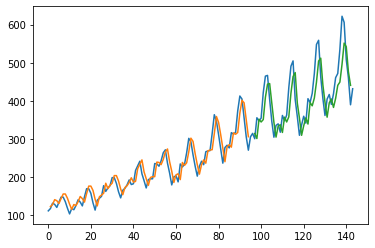

In [ ]:
# LSTM for international airline passengers problem with regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = df_g_smap.copy(deep=True)
#dataframe = read_csv('/content/drive/MyDrive/272/lstm.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
import pickle
filename = '/content/drive/MyDrive/272/statemap.pkl'
pickle.dump(model, open(filename, 'wb'))

# Extracting Useful Features

In [ ]:
ef = df[["state_name", "state_code", "county_name", "county_code"]]
se = ef[["state_name", "state_code"]].drop_duplicates(keep='first')
se["state_code"] = se["state_code"].astype(int)
dict(se.values)

{'Alabama': 1,
 'Alaska': 2,
 'Arizona': 4,
 'Arkansas': 5,
 'California': 6,
 'Colorado': 8,
 'Connecticut': 9,
 'Country Of Mexico': 80,
 'Delaware': 10,
 'District Of Columbia': 11,
 'Florida': 12,
 'Georgia': 13,
 'Hawaii': 15,
 'Idaho': 16,
 'Illinois': 17,
 'Indiana': 18,
 'Iowa': 19,
 'Kansas': 20,
 'Kentucky': 21,
 'Louisiana': 22,
 'Maine': 23,
 'Maryland': 24,
 'Massachusetts': 25,
 'Michigan': 26,
 'Minnesota': 27,
 'Mississippi': 28,
 'Missouri': 29,
 'Montana': 30,
 'Nebraska': 31,
 'Nevada': 32,
 'New Hampshire': 33,
 'New Jersey': 34,
 'New Mexico': 35,
 'New York': 36,
 'North Carolina': 37,
 'North Dakota': 38,
 'Ohio': 39,
 'Oklahoma': 40,
 'Oregon': 41,
 'Pennsylvania': 42,
 'Puerto Rico': 72,
 'Rhode Island': 44,
 'South Carolina': 45,
 'South Dakota': 46,
 'Tennessee': 47,
 'Texas': 48,
 'Utah': 49,
 'Vermont': 50,
 'Virginia': 51,
 'Washington': 53,
 'West Virginia': 54,
 'Wisconsin': 55,
 'Wyoming': 56}

In [ ]:
ce = ef[["county_name", "county_code"]].drop_duplicates(keep='first')
ce["county_code"] = ce["county_code"].astype(int)
dict(ce.values)

{'Ada': 1,
 'Adair': 1,
 'Adams': 1,
 'Alameda': 1,
 'Albany': 1,
 'Alexandria City': 510,
 'Allegheny': 3,
 'Allen': 3,
 'Anchorage ': 20,
 'Anoka': 3,
 'Arlington': 13,
 'Aroostook': 3,
 'Athens': 9,
 'BAJA CALIFORNIA NORTE': 2,
 'Baltimore': 5,
 'Baltimore (City)': 510,
 'Bayamon': 21,
 'Belmont': 13,
 'Bergen': 3,
 'Berks': 11,
 'Bernalillo': 1,
 'Bexar': 29,
 'Blount': 9,
 'Boulder': 13,
 'Bronx': 5,
 'Brooke': 9,
 'Broward': 11,
 'Bucks': 17,
 'Burleigh': 15,
 'Burlington': 5,
 'Butte': 7,
 'CHIHUAHUA STATE': 6,
 'Caguas': 25,
 'Cambria': 21,
 'Camden': 7,
 'Cameron': 61,
 'Cascade': 13,
 'Cass': 17,
 'Champaign': 19,
 'Charleston': 19,
 'Cherokee': 21,
 'Cheshire': 5,
 'Chittenden': 7,
 'Clallam': 9,
 'Clark': 3,
 'Contra Costa': 13,
 'Converse': 9,
 'Cook': 31,
 'Cumberland': 5,
 'Cuyahoga': 35,
 'Dakota': 37,
 'Dallas': 113,
 'Dauphin': 43,
 'Davidson': 37,
 'DeKalb': 89,
 'Denver': 31,
 'District of Columbia': 1,
 'Dodge': 27,
 'Dorchester': 19,
 'Douglas': 5,
 'Duchesne': 13

In [ ]:
statenames = ["Alaska",
                  "Alabama",
                  "Arkansas",
                  "American Samoa",
                  "Arizona",
                  "California",
                  "Colorado",
                  "Connecticut",
                  "District of Columbia",
                  "Delaware",
                  "Florida",
                  "Georgia",
                  "Guam",
                  "Hawaii",
                  "Iowa",
                  "Idaho",
                  "Illinois",
                  "Indiana",
                  "Kansas",
                  "Kentucky",
                  "Louisiana",
                  "Massachusetts",
                  "Maryland",
                  "Maine",
                  "Michigan",
                  "Minnesota",
                  "Missouri",
                  "Mississippi",
                  "Montana",
                  "North Carolina",
                  " North Dakota",
                  "Nebraska",
                  "New Hampshire",
                  "New Jersey",
                  "New Mexico",
                  "Nevada",
                  "New York",
                  "Ohio",
                  "Oklahoma",
                  "Oregon",
                  "Pennsylvania",
                  "Puerto Rico",
                  "Rhode Island",
                  "South Carolina",
                  "South Dakota",
                  "Tennessee",
                  "Texas",
                  "Utah",
                  "Virginia",
                  "Virgin Islands",
                  "Vermont",
                  "Washington",
                  "Wisconsin",
                  "West Virginia",
                  "Wyoming"]

In [ ]:
efcn = ef[ef["state_name"].isin(["Alaska",
                  "Alabama",
                  "Arkansas",
                  "American Samoa",
                  "Arizona",
                  "California",
                  "Colorado",
                  "Connecticut",
                  "District of Columbia",
                  "Delaware",
                  "Florida",
                  "Georgia",
                  "Guam",
                  "Hawaii",
                  "Iowa",
                  "Idaho",
                  "Illinois",
                  "Indiana",
                  "Kansas",
                  "Kentucky",
                  "Louisiana",
                  "Massachusetts",
                  "Maryland",
                  "Maine",
                  "Michigan",
                  "Minnesota",
                  "Missouri",
                  "Mississippi",
                  "Montana",
                  "North Carolina",
                  " North Dakota",
                  "Nebraska",
                  "New Hampshire",
                  "New Jersey",
                  "New Mexico",
                  "Nevada",
                  "New York",
                  "Ohio",
                  "Oklahoma",
                  "Oregon",
                  "Pennsylvania",
                  "Puerto Rico",
                  "Rhode Island",
                  "South Carolina",
                  "South Dakota",
                  "Tennessee",
                  "Texas",
                  "Utah",
                  "Virginia",
                  "Virgin Islands",
                  "Vermont",
                  "Washington",
                  "Wisconsin",
                  "West Virginia",
                  "Wyoming"])].reset_index(drop=True)[["state_name", "county_name"]]
efcn = efcn.drop_duplicates(keep='first').reset_index(drop=True)
ddict = {}
for i in statenames:
  ddict[i] = list(efcn[efcn["state_name"]==i]["county_name"].values)
  #ddict["Nevada"] = list(efcn[efcn["state_name"]=="Nevada"]["county_name"].values)

In [ ]:
ddict

{' North Dakota': [],
 'Alabama': ['Jefferson'],
 'Alaska': ['Anchorage ', 'Fairbanks North Star '],
 'American Samoa': [],
 'Arizona': ['La Paz', 'Pima', 'Maricopa'],
 'Arkansas': ['Pulaski'],
 'California': ['Kern',
  'Santa Clara',
  'Fresno',
  'San Diego',
  'Santa Barbara',
  'Los Angeles',
  'Orange',
  'Riverside',
  'San Bernardino',
  'Marin',
  'Inyo',
  'Butte',
  'Contra Costa',
  'Sacramento',
  'Napa',
  'Sonoma',
  'Santa Cruz',
  'Solano',
  'Madera',
  'Sutter',
  'Imperial',
  'Stanislaus',
  'San Francisco',
  'Alameda',
  'San Mateo',
  'San Joaquin',
  'Monterey',
  'Humboldt'],
 'Colorado': ['La Plata',
  'Denver',
  'Jackson',
  'Boulder',
  'Weld',
  'El Paso',
  'Mesa',
  'Larimer',
  'Adams'],
 'Connecticut': ['Fairfield', 'New Haven', 'Litchfield', 'Hartford'],
 'Delaware': ['New Castle'],
 'District of Columbia': [],
 'Florida': ['Duval',
  'Pinellas',
  'Hillsborough',
  'Broward',
  'Miami-Dade',
  'Wakulla',
  'Orange'],
 'Georgia': ['Fulton', 'DeKalb', 

In [ ]:
{'California': ['Kern',
  'Fresno',
  'San Diego',
  'Santa Barbara',
  'Los Angeles',
  'Orange',
  'Santa Clara',
  'Riverside',
  'San Bernardino',
  'Marin',
  'Butte',
  'Inyo',
  'Contra Costa',
  'Sacramento',
  'Napa',
  'Sonoma',
  'Santa Cruz',
  'Solano',
  'Madera',
  'Sutter',
  'Imperial',
  'Stanislaus',
  'San Francisco',
  'Alameda',
  'San Mateo',
  'San Joaquin',
  'Monterey',
  'Humboldt'],
 'Nevada': ['Washoe', 'Clark', 'Douglas']}

{'California': ['Kern',
  'Fresno',
  'San Diego',
  'Santa Barbara',
  'Los Angeles',
  'Orange',
  'Santa Clara',
  'Riverside',
  'San Bernardino',
  'Marin',
  'Butte',
  'Inyo',
  'Contra Costa',
  'Sacramento',
  'Napa',
  'Sonoma',
  'Santa Cruz',
  'Solano',
  'Madera',
  'Sutter',
  'Imperial',
  'Stanislaus',
  'San Francisco',
  'Alameda',
  'San Mateo',
  'San Joaquin',
  'Monterey',
  'Humboldt'],
 'Nevada': ['Washoe', 'Clark', 'Douglas']}

In [ ]:
ff = df[["state_name", "state_code", "county_name", "county_code", 'city_name']]
ff = ff[ff["city_name"]!="Not in a city"].reset_index(drop=True)
efcnc = ff[ff["state_name"].isin(statenames)].reset_index(drop=True)[["state_name", "county_name", "city_name"]]
efcnc = efcnc.drop_duplicates(keep='first').reset_index(drop=True)
ddictc = {}

for i in list(set(efcnc["county_name"].values)):
  ddictc[i] = list(efcnc[efcnc["county_name"]==i]["city_name"].values)
ddictc

{'Ada': ['Boise (corporate name Boise City)', 'Meridian'],
 'Adair': ['Cherry Tree'],
 'Adams': ['Welby'],
 'Alameda': ['Livermore', 'Oakland', 'Pleasanton', 'Fremont', 'Berkeley'],
 'Albany': ['Albany'],
 'Alexandria City': ['Alexandria'],
 'Allegheny': ['Pittsburgh', 'Wilkinsburg'],
 'Allen': ['Fort Wayne'],
 'Anchorage ': ['Anchorage'],
 'Anoka': ['Blaine'],
 'Arlington': ['Arlington'],
 'Aroostook': ['Presque Isle'],
 'Athens': ['Athens'],
 'Baltimore': ['Essex'],
 'Baltimore (City)': ['Baltimore'],
 'Bayamon': ['Bayamon'],
 'Belmont': ['Shadyside'],
 'Bergen': ['Fort Lee', 'Hackensack'],
 'Bernalillo': ['North Valley', 'Albuquerque', 'South Valley'],
 'Bexar': ['San Antonio'],
 'Boulder': ['Longmont'],
 'Bronx': ['New York'],
 'Brooke': ['Weirton'],
 'Broward': ['Fort Lauderdale', 'Davie', 'Pompano Beach', 'Hollywood'],
 'Bucks': ['Bristol'],
 'Burlington': ['Burlington'],
 'Butte': ['Chico'],
 'Caguas': ['Caguas'],
 'Cambria': ['Johnstown'],
 'Camden': ['Camden', 'Winslow (Townsh